In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# mehr nichtlinear/kompliziertere Gleichungen
# Benchmark dataset
# https://arxiv.org/pdf/2102.08351
# https://github.com/jongeunkim/STreCH/data

def data_generation(length: int = 100, 
                    ds_error: float = 0.1, 
                    means = (0, 1, 3), 
                    vars = (1, .1, 5), 
                    seed: int = 42):
    # generates a dataset of the form y = (1 * a) * (1.5 * b) - (0.5 * c)
    np.random.seed(seed)
    a = np.random.normal(means[0], vars[0], length)
    b = np.random.normal(means[1], vars[1], length)
    c = np.random.normal(means[2], vars[2], length)
    y = (1 * a) * (1.5 * b) - (0.5 * c)
    y = y + np.random.normal(0, ds_error, length)
    x = np.stack((a, b, c), axis=1)
    # make a train and test split
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)
    return x_train, y_train, x_test, y_test

# MIP, GPlearn, optimized GPlearn für Vortrag erklären

In [5]:
import time
from gplearn.genetic import SymbolicRegressor

def evaluate_regressor(length: int = 100, 
                       ds_error: float = 0.1, 
                       means = (0, 1, 3), 
                       vars = (1, .1, 5), 
                       optimized: bool = True,
                       seed: int = 42):
    # generate data given the parameters
    x_train, y_train, x_test, y_test = data_generation(length, ds_error, means, vars, seed)

    if optimized:
        print("Optimized regressor")
        regressor = SymbolicRegressor(population_size=100,
                                      generations=200, stopping_criteria=0.01,
                                      init_depth=(2, 4),
                                      optimize_constants=True,
                                      p_crossover=0.7, p_subtree_mutation=0.1,
                                      p_hoist_mutation=0.05, p_point_mutation=0.1,
                                      max_samples=0.9, verbose=0,
                                      parsimony_coefficient=0.01, random_state=42)
    else:
        print("Default regressor")
        regressor = SymbolicRegressor(population_size=5000,
                                      generations=20, stopping_criteria=0.01,
                                      init_depth=(2, 6),
                                      p_crossover=0.7, p_subtree_mutation=0.1,
                                      p_hoist_mutation=0.05, p_point_mutation=0.1,
                                      max_samples=0.9, verbose=0,
                                      parsimony_coefficient=0.01, random_state=0)
    # fit and time the optimized regressor
    start_time = time.time()
    regressor.fit(x_train, y_train)
    end_time = time.time()

    score = regressor.score(x_test, y_test)
    error = np.mean(np.abs(regressor.predict(x_test) - y_test))

    print(f"regressor score: {score}")
    print(f"regressor error: {error}")
    print(f"regressor time: {end_time - start_time:.2f} seconds")
    return score, error, end_time - start_time, 



In [6]:
# default parameters for reference
default_optimized = evaluate_regressor(optimized=True)
default_unoptimized = evaluate_regressor(optimized=False)

Optimized regressor
regressor score: 0.9984278409060291
regressor error: 0.05673804755059164
regressor time: 32.95 seconds
Default regressor
regressor score: 0.9973935721237174
regressor error: 0.06928309641299085
regressor time: 68.34 seconds


In [7]:
print("no error in the dataset: 0.0")
no_error_optimized = evaluate_regressor(ds_error=0.0, optimized=True)
no_error_unoptimized = evaluate_regressor(ds_error=0.0, optimized=False)
print("small error in the dataset: 0.1")
small_error_optimized = evaluate_regressor(ds_error=0.1, optimized=True)
small_error_unoptimized = evaluate_regressor(ds_error=0.1, optimized=False)
print("medium error in the dataset: 0.5")
medium_error_optimized = evaluate_regressor(ds_error=0.5, optimized=True)
medium_error_unoptimized = evaluate_regressor(ds_error=0.5, optimized=False)
print("large error in the dataset: 1.0")
large_error_optimized = evaluate_regressor(ds_error=1.0, optimized=True)
large_error_unoptimized = evaluate_regressor(ds_error=1.0, optimized=False)

no error in the dataset: 0.0
Optimized regressor
regressor score: 1.0
regressor error: 3.4960973921416282e-09
regressor time: 0.33 seconds
Default regressor
regressor score: 0.9995545932247774
regressor error: 0.030140202986993096
regressor time: 59.55 seconds
small error in the dataset: 0.1
Optimized regressor
regressor score: 0.9984278409060291
regressor error: 0.05673804755059164
regressor time: 30.79 seconds
Default regressor
regressor score: 0.9973935721237174
regressor error: 0.06928309641299085
regressor time: 59.93 seconds
medium error in the dataset: 0.5
Optimized regressor
regressor score: -0.3859349573219899
regressor error: 1.7070638641571456
regressor time: 13.36 seconds
Default regressor
regressor score: 0.955957407818726
regressor error: 0.28847161585355685
regressor time: 64.27 seconds
large error in the dataset: 1.0
Optimized regressor
regressor score: -0.21101642093085893
regressor error: 1.6957493968784498
regressor time: 13.54 seconds
Default regressor
regressor sco

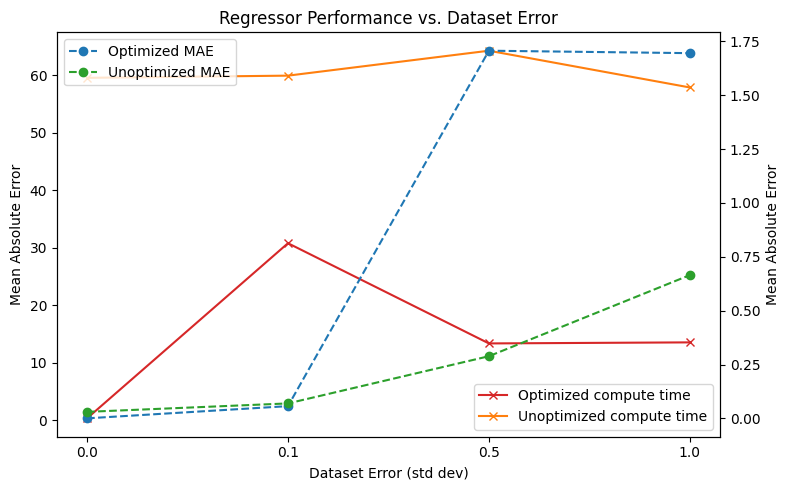

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_results(optimized_results, unoptimized_results, labels, title, varname):
    # Collect the results
    optimized_mae = [result[1] for result in optimized_results]
    unoptimized_mae = [result[1] for result in unoptimized_results]
    optimized_times = [result[2] for result in optimized_results]
    unoptimized_times = [result[2] for result in unoptimized_results]

    x = np.arange(len(labels))

    fig, ax1 = plt.subplots(figsize=(8,5))

    # Plot R^2 scores
    ax1.plot(x, optimized_times, 'x-', color='tab:red', label='Optimized compute time')
    ax1.plot(x, unoptimized_times, 'x-', color='tab:orange', label='Unoptimized compute time')
    ax1.set_xlabel(varname)
    ax1.set_ylabel('compute Time')
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels)
    ax1.legend(loc='best')
    ax1.set_title(title)

    # Plot MAE on secondary axis
    ax2 = ax1.twinx()
    ax2.plot(x, optimized_mae, 'o--', color='tab:blue', label='Optimized MAE')
    ax2.plot(x, unoptimized_mae, 'o--', color='tab:green', label='Unoptimized MAE')
    ax2.set_ylabel('Mean Absolute Error')
    ax2.legend(loc='best')

    plt.tight_layout()
    plt.show()

plot_results([no_error_optimized, small_error_optimized, medium_error_optimized, large_error_optimized], 
             [no_error_unoptimized, small_error_unoptimized, medium_error_unoptimized, large_error_unoptimized], 
             [0.0, 0.1, 0.5, 1.0],
             'Regressor Performance vs. Dataset Error',
             'Dataset Error (std dev)'
             )

In [9]:
print("small dataset: 10 samples")
small_data_optimized = evaluate_regressor(length=10, optimized=True)
small_data_unoptimized = evaluate_regressor(length=10, optimized=False)
print("large dataset: 1000 samples")
large_data_optimized = evaluate_regressor(length=1000, optimized=True)
large_data_unoptimized = evaluate_regressor(length=1000, optimized=False)

small dataset: 10 samples
Optimized regressor
regressor score: -3.66602664931571
regressor error: 0.17312877484377015
regressor time: 0.80 seconds
Default regressor
regressor score: -2.416549650433105
regressor error: 0.15304096422958974
regressor time: 57.38 seconds
large dataset: 1000 samples
Optimized regressor
regressor score: 0.21394141743521045
regressor error: 2.057830708740989
regressor time: 13.17 seconds
Default regressor
regressor score: 0.998718012354896
regressor error: 0.0823791273589208
regressor time: 61.56 seconds


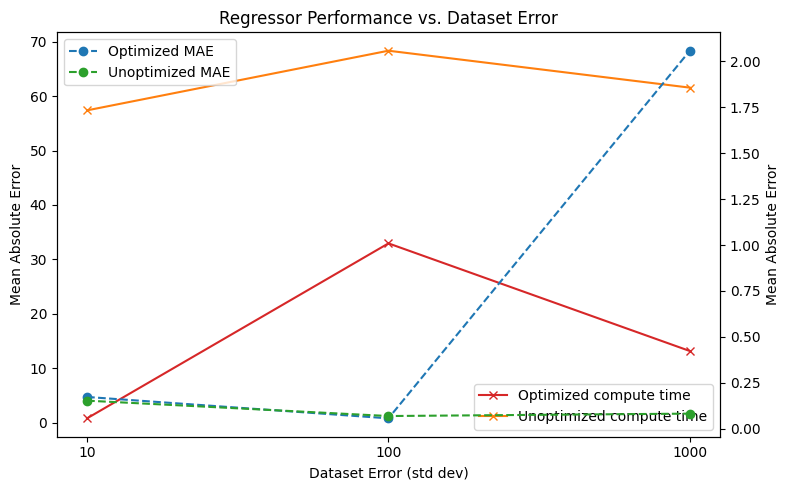

In [31]:
plot_results([small_data_optimized, default_optimized, large_data_optimized],
             [small_data_unoptimized, default_unoptimized, large_data_unoptimized], 
             [10, 100, 1000])

In [10]:
print("a, b, c in dataset are close to each other: 0, 0, 0")
close_means_optimized = evaluate_regressor(means=(0, 0, 0), optimized=True)
close_means_unoptimized = evaluate_regressor(means=(0, 0, 0), optimized=False)
print("a, b, c in dataset are far from each other: 0, 10, 20")
far_means_optimized = evaluate_regressor(means=(0, 10, 20), optimized=True)
far_means_unoptimized = evaluate_regressor(means=(0, 10, 20), optimized=False)

a, b, c in dataset are close to each other: 0, 0, 0
Optimized regressor
regressor score: 0.9990371174238002
regressor error: 0.05302644276863968
regressor time: 18.59 seconds
Default regressor
regressor score: 0.9989842951012847
regressor error: 0.05578443060064262
regressor time: 61.56 seconds
a, b, c in dataset are far from each other: 0, 10, 20
Optimized regressor
regressor score: 0.9999578940346996
regressor error: 0.06078279443033243
regressor time: 36.89 seconds
Default regressor
regressor score: 0.9997938996879233
regressor error: 0.12492604059204226
regressor time: 59.58 seconds


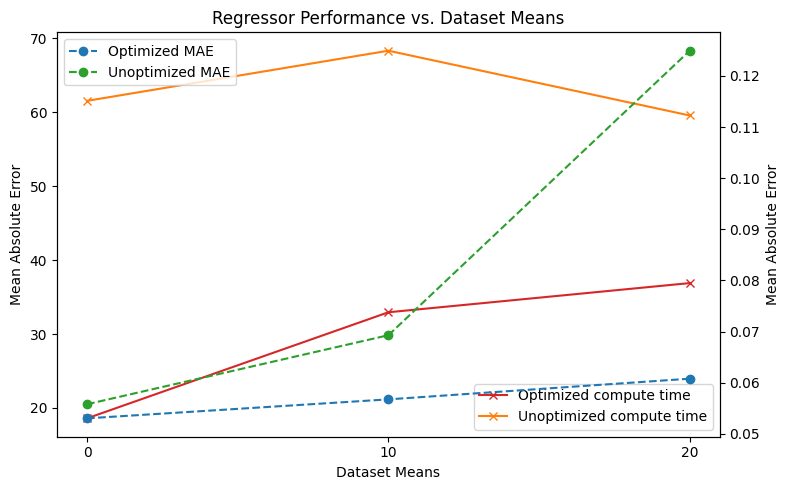

In [34]:
plot_results([close_means_optimized, default_optimized, far_means_optimized],
             [close_means_unoptimized, default_unoptimized, far_means_unoptimized], 
             [0, 10, 20],
             'Regressor Performance vs. Dataset Means',
             'Dataset Means'
             )

In [11]:
print("a, b, c have similar variance: 1, 1, 1")
similar_vars_optimized = evaluate_regressor(vars=(1, 1, 1), optimized=True)
similar_vars_unoptimized = evaluate_regressor(vars=(1, 1, 1), optimized=False)
print("a, b, c have different variance: 1, 0.1, 5")
different_vars_optimized = evaluate_regressor(vars=(1, 0.1, 5), optimized=True)
different_vars_unoptimized = evaluate_regressor(vars=(1, 0.1, 5), optimized=False)

a, b, c have similar variance: 1, 1, 1
Optimized regressor
regressor score: 0.9212744036469296
regressor error: 0.28986875596895506
regressor time: 12.54 seconds
Default regressor
regressor score: 0.9884212044824646
regressor error: 0.13999229985695028
regressor time: 59.57 seconds
a, b, c have different variance: 1, 0.1, 5
Optimized regressor
regressor score: 0.9984278409060291
regressor error: 0.05673804755059164
regressor time: 30.80 seconds
Default regressor
regressor score: 0.9973935721237174
regressor error: 0.06928309641299085
regressor time: 56.20 seconds


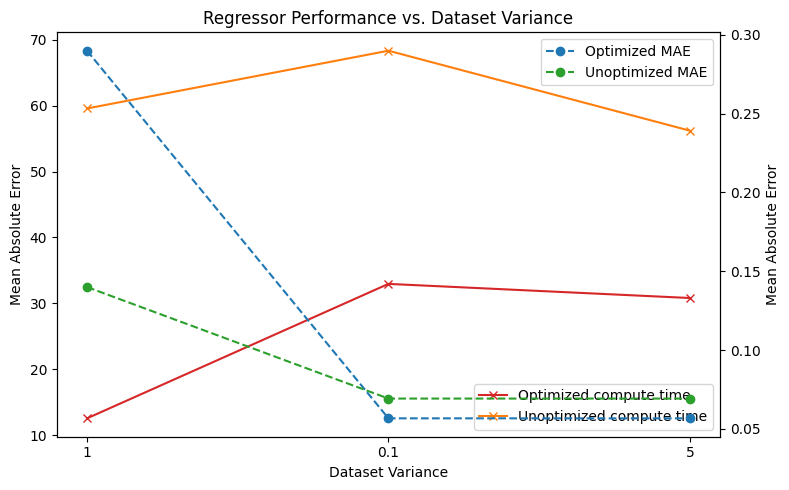

In [35]:
plot_results([similar_vars_optimized, default_optimized, different_vars_optimized],
             [similar_vars_unoptimized, default_unoptimized, different_vars_unoptimized], 
             [1, 0.1, 5],
             'Regressor Performance vs. Dataset Variance',
             'Dataset Variance'
             )